# Finetune `wav2vec2` for Thai

This notebook is adapted from [Fine-tuning Wav2Vec2 for English ASR](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb) to train Thai ASR using [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets).

## What is `wav2vec2`

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

## Installs and Imports

We use SageMaker Studio `Python 3 (Data Science)` image as base.

In [3]:
%%capture
!apt-get update
!apt-get install --reinstall build-essential --yes

In [4]:
%%capture
# !pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install datasets==1.11.0
!pip install transformers==4.9.1
!pip install jiwer
!pip install ipywidgets
!pip install pythainlp==2.3.1
!pip install tensorboard==2.5.0

In [1]:
from functools import partial
import pandas as pd
import numpy as np
from datasets import (
    load_dataset, 
    load_from_disk,
    load_metric,)
from datasets.filesystems import S3FileSystem
from transformers import (
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer,
)
import torchaudio
import re
import json
from pythainlp.tokenize import word_tokenize, syllable_tokenize

In [2]:
!df -h

Filesystem         Size  Used Avail Use% Mounted on
overlay             17G  4.6G   13G  28% /
tmpfs               64M     0   64M   0% /dev
tmpfs              7.7G     0  7.7G   0% /sys/fs/cgroup
shm                 64M     0   64M   0% /dev/shm
127.0.0.1:/200005  8.0E   69G  8.0E   1% /root
/dev/nvme0n1p1      83G   17G   67G  20% /usr/bin/nvidia-smi
devtmpfs           7.7G     0  7.7G   0% /dev/tty
tmpfs              7.7G   12K  7.7G   1% /proc/driver/nvidia
tmpfs              7.7G     0  7.7G   0% /proc/acpi
tmpfs              7.7G     0  7.7G   0% /sys/firmware


## Data Preparation

### Download

Download and extract to `data/cv-corpus-7.0-2021-07-21-th/th`

In [7]:
# !wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-7.0-2021-07-21/cv-corpus-7.0-2021-07-21-th.tar.gz
# !tar -xvf cv-corpus-7.0-2021-07-21-th.tar.gz --no-same-owner

### Clean

Clean the datasets as described in `cv-preprocess.ipynb` by [@tann9949](https://github.com/tann9949).

### Load Dataset

We use the [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets) which contains 133 validated hours of Thai (255 total hours) at 5GB. We pre-tokenize with `pythainlp.tokenize.word_tokenize`.

In [3]:
datasets = load_dataset("../scripts/th_common_voice_70.py", "th")
datasets

Reusing dataset common_voice (/root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701)


DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 23332
    })
    test: Dataset({
        features: ['path', 'sentence'],
        num_rows: 9709
    })
    validation: Dataset({
        features: ['path', 'sentence'],
        num_rows: 9711
    })
})

In [4]:
def preprocess_data(example, tok_func = word_tokenize):
    example['sentence'] = ' '.join(tok_func(example['sentence']))
    return example

datasets = datasets.map(preprocess_data)

Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-a3d889e9ad8e5f77.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-ec2dd59eee249bac.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-80e8fc3955fbe3ae.arrow


### Exploration

#### `sentence`; transcripts

In [10]:
#show random sentences
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))
    
show_random_elements(datasets["train"].remove_columns(["path"]), num_examples=20)

,sentence
0,เขา วางเดิมพัน กับ ผลลัพธ์ ของ มัน
1,รอยยิ้ม กว้าง ของ เขา ทำให้ เขา มี เพื่อน มากมาย
2,การประกอบโรคศิลปะ
3,เดี๋ยวนี้ มี ปลา กุเลา เค็ม จาก หลาย แหล่ง
4,อัน ได้แก่
5,ดิสเคานต์สโตร์
6,ปัน หยี แป ลงกา ยา เป็น อา หยัน
7,อเนกชาติภุชงค์
8,การ เก็บรักษา ลูกเรือ เป็นปัญหา ใหญ่ ใน ปี ที่ผ่านมา
9,สุขภาพ


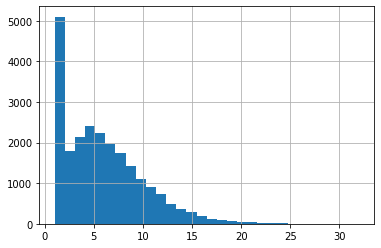

In [6]:
train_df = pd.DataFrame({'sentence':datasets['train']['sentence']})
train_df['nb_words'] = train_df.sentence.map(lambda x: len(x.split()))
train_df.nb_words.hist(bins=30)

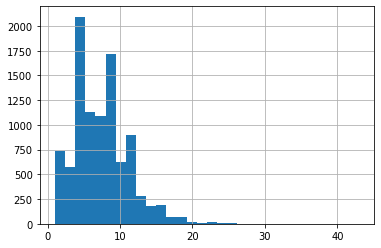

In [7]:
validation_df = pd.DataFrame({'sentence':datasets['validation']['sentence']})
validation_df['nb_words'] = validation_df.sentence.map(lambda x: len(x.split()))
validation_df.nb_words.hist(bins=30)

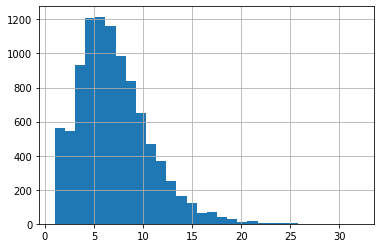

In [8]:
test_df = pd.DataFrame({'sentence':datasets['test']['sentence']})
test_df['nb_words'] = test_df.sentence.map(lambda x: len(x.split()))
test_df.nb_words.hist(bins=30)

#### `path`; mp3 files

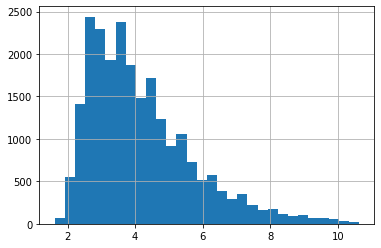

In [50]:
train_df = pd.DataFrame({'path':datasets['train']['path']})
train_df['sample_rate'] = train_df.path.map(lambda x: torchaudio.info(x).sample_rate)
train_df['num_frames'] = train_df.path.map(lambda x: torchaudio.info(x).num_frames)
train_df['seconds'] = train_df.num_frames / train_df.sample_rate
train_df.seconds.hist(bins=30)

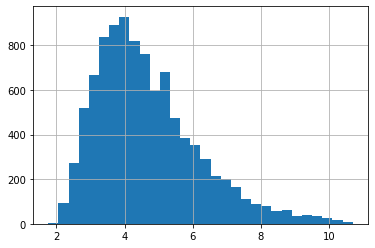

In [51]:
validation_df = pd.DataFrame({'path':datasets['validation']['path']})
validation_df['sample_rate'] = validation_df.path.map(lambda x: torchaudio.info(x).sample_rate)
validation_df['num_frames'] = validation_df.path.map(lambda x: torchaudio.info(x).num_frames)
validation_df['seconds'] = validation_df.num_frames / validation_df.sample_rate
validation_df.seconds.hist(bins=30)

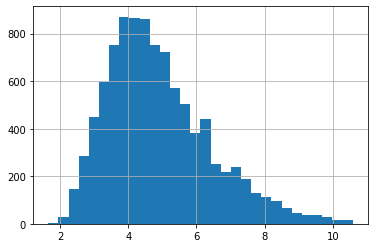

In [52]:
test_df = pd.DataFrame({'path':datasets['test']['path']})
test_df['sample_rate'] = test_df.path.map(lambda x: torchaudio.info(x).sample_rate)
test_df['num_frames'] = test_df.path.map(lambda x: torchaudio.info(x).num_frames)
test_df['seconds'] = test_df.num_frames / test_df.sample_rate
test_df.seconds.hist(bins=30)

### Create Wav2Vec2CTCTokenizer

[Connectionist Temporal Classification (CTC)](https://distill.pub/2017/ctc/) tokenizer is a character-level tokenizer. We uses space (denoted as `|` token) as word delimiter token and `[PAD]` as blank token. 

In [11]:
def extract_all_chars(batch, text_col = "sentence"):
    all_text = " ".join(batch[text_col])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = datasets.map(extract_all_chars, 
                   batched=True, 
                   batch_size=-1, 
                   keep_in_memory=True, 
                   remove_columns=datasets.column_names["train"])

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["validation"]["vocab"][0]) |set(vocabs["test"]["vocab"][0]))
# vocab_list = list(set(vocabs["train"]["vocab"][0])) #strictly no leakage
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
len(vocab_dict), vocab_dict

(70,
 {'ฏ': 0,
  'ั': 1,
  'ม': 2,
  'ศ': 3,
  'ฬ': 4,
  'ฆ': 5,
  'ธ': 6,
  'ใ': 7,
  'ึ': 8,
  'ญ': 9,
  '็': 10,
  'ี': 11,
  'ท': 12,
  'ร': 13,
  'ฝ': 14,
  '์': 15,
  'ฃ': 16,
  'ณ': 17,
  ' ': 18,
  'ไ': 19,
  'ษ': 20,
  'ฒ': 21,
  'ิ': 22,
  '้': 23,
  "'": 24,
  'แ': 25,
  'ื': 26,
  'ำ': 27,
  'ฌ': 28,
  'ะ': 29,
  'ถ': 30,
  'ข': 31,
  'ุ': 32,
  'บ': 33,
  'ฉ': 34,
  'า': 35,
  '๊': 36,
  '๋': 37,
  'ซ': 38,
  '่': 39,
  'ภ': 40,
  'ฟ': 41,
  'ฯ': 42,
  'ด': 43,
  'โ': 44,
  'ช': 45,
  'ล': 46,
  'ต': 47,
  'ก': 48,
  'น': 49,
  'ส': 50,
  'ว': 51,
  'ฎ': 52,
  'ู': 53,
  'ฐ': 54,
  'เ': 55,
  'อ': 56,
  'ค': 57,
  'ฤ': 58,
  'ๅ': 59,
  'จ': 60,
  'ย': 61,
  'ห': 62,
  'ง': 63,
  'ป': 64,
  'ผ': 65,
  'ฮ': 66,
  'ฑ': 67,
  '.': 68,
  'พ': 69})

In [12]:
#make space = |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [13]:
#padding token serves as blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict), vocab_dict

(72,
 {'ฏ': 0,
  'ั': 1,
  'ม': 2,
  'ศ': 3,
  'ฬ': 4,
  'ฆ': 5,
  'ธ': 6,
  'ใ': 7,
  'ึ': 8,
  'ญ': 9,
  '็': 10,
  'ี': 11,
  'ท': 12,
  'ร': 13,
  'ฝ': 14,
  '์': 15,
  'ฃ': 16,
  'ณ': 17,
  'ไ': 19,
  'ษ': 20,
  'ฒ': 21,
  'ิ': 22,
  '้': 23,
  "'": 24,
  'แ': 25,
  'ื': 26,
  'ำ': 27,
  'ฌ': 28,
  'ะ': 29,
  'ถ': 30,
  'ข': 31,
  'ุ': 32,
  'บ': 33,
  'ฉ': 34,
  'า': 35,
  '๊': 36,
  '๋': 37,
  'ซ': 38,
  '่': 39,
  'ภ': 40,
  'ฟ': 41,
  'ฯ': 42,
  'ด': 43,
  'โ': 44,
  'ช': 45,
  'ล': 46,
  'ต': 47,
  'ก': 48,
  'น': 49,
  'ส': 50,
  'ว': 51,
  'ฎ': 52,
  'ู': 53,
  'ฐ': 54,
  'เ': 55,
  'อ': 56,
  'ค': 57,
  'ฤ': 58,
  'ๅ': 59,
  'จ': 60,
  'ย': 61,
  'ห': 62,
  'ง': 63,
  'ป': 64,
  'ผ': 65,
  'ฮ': 66,
  'ฑ': 67,
  '.': 68,
  'พ': 69,
  '|': 18,
  '[UNK]': 70,
  '[PAD]': 71})

In [14]:
#save as json
with open('../data/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [5]:
tokenizer = Wav2Vec2CTCTokenizer("../data/vocab.json", 
                                 unk_token="[UNK]", 
                                 pad_token="[PAD]", 
                                 word_delimiter_token="|")

In [6]:
datasets['train'][0]['sentence']

'มัน เป็นเรื่อง ที่ ดี ที่ การ เดินทาง ย้อน เวลา ไม่ ได้ มี อยู่ จริง'

In [7]:
tokenizer(datasets['train'][0]['sentence'])

{'input_ids': [2, 1, 49, 18, 55, 64, 10, 49, 55, 13, 26, 39, 56, 63, 18, 12, 11, 39, 18, 43, 11, 18, 12, 11, 39, 18, 48, 35, 13, 18, 55, 43, 22, 49, 12, 35, 63, 18, 61, 23, 56, 49, 18, 55, 51, 46, 35, 18, 19, 2, 39, 18, 19, 43, 23, 18, 2, 11, 18, 56, 61, 53, 39, 18, 60, 13, 22, 63], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
tokenizer.decode(tokenizer(datasets['train'][0]['sentence']).input_ids)

'มัน เป็นเรื่อง ที่ ดี ที่ การ เดินทาง ย้อน เวลา ไม่ ได้ มี อยู่ จริง'

### Create Wav2Vec2 Feature Extractor

Wav2Vec2 was pretrained on the audio data of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) and LibriVox which both were sampling with 16kHz. [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets) has 32kHz sampling rate.

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. **Important** If you want to use this notebook to fine-tune [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60), this parameter should be set to `True`.

In [9]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, 
                                             sampling_rate=16000, 
                                             padding_value=0.0, 
                                             do_normalize=True, 
                                             return_attention_mask=False)

In [10]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

### Preprocess Data

We resample to 16kHz with which `wav2vec2` was pretrained on.

In [11]:
def speech_file_to_array_fn(batch, 
                            text_col="sentence", 
                            fname_col="path",
                            resampling_to=16000):
    speech_array, sampling_rate = torchaudio.load(batch[fname_col])
    resampler=torchaudio.transforms.Resample(sampling_rate, resampling_to)
    batch["speech"] = resampler(speech_array)[0].numpy()
    batch["sampling_rate"] = resampling_to
    batch["target_text"] = batch[text_col]
    return batch

In [12]:
speech_datasets = datasets.map(speech_file_to_array_fn, 
                                   remove_columns=datasets.column_names["train"])
speech_datasets

Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-f5e3fd6d91d946ed.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-a168c1d71b35662f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-38dd70eaadaccf26.arrow


DatasetDict({
    train: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 23332
    })
    test: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 9709
    })
    validation: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 9711
    })
})

In [13]:
#sample sounds
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(speech_datasets["train"]))
print(speech_datasets["train"][rand_int]["target_text"])
ipd.Audio(data=np.asarray(speech_datasets["train"][rand_int]["speech"]), autoplay=True, rate=16000)

คุณ กำลัง เดิน ขา เป๋ ด้วย ไม้เท้า


Then we prepare `input_values` using processor and labels using `target_text`.

In [14]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [15]:
prepared_datasets = speech_datasets.map(prepare_dataset, 
                                        remove_columns=speech_datasets.column_names["train"], 
                                        batch_size=16,
                                        batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-5ea281425e5c2dbd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-0e0d3efc7a7b2ce0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701/cache-90db8f9574eb9f18.arrow


In [31]:
# credentials = pd.read_csv('../data/rootkey.csv',header=None)
# aws_access_key_id = credentials.iloc[0,0].split('=')[-1]
# aws_secret_access_key = credentials.iloc[1,0].split('=')[-1]
# s3 = S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)  
# prepared_datasets.save_to_disk('s3://sagemaker-studio-g2rfihg7k9q/wav2vec2-large-xlsr-th/', fs=s3)  
# !aws s3 ls --summarize --human-readable --recursive s3://sagemaker-studio-g2rfihg7k9q/wav2vec2-large-xlsr-th/

In [ ]:
# credentials = pd.read_csv('../data/rootkey.csv',header=None)
# aws_access_key_id = credentials.iloc[0,0].split('=')[-1]
# aws_secret_access_key = credentials.iloc[1,0].split('=')[-1]
# s3 = S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)  
# prepared_datasets = load_from_disk('s3://sagemaker-studio-g2rfihg7k9q/wav2vec2-large-xlsr-th/', fs=s3)

In [16]:
prepared_datasets

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 23332
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 9709
    })
    validation: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 9711
    })
})

## Training

### Data Collator

In [17]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [18]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Metric

We use word error rate with space as word boundary. We created those spaces using `pythainlp.tokenize.word_tokenize` (2.3.1).

In [19]:
wer_metric = load_metric("wer")

In [20]:
wer_metric.compute(predictions=['สวัสดี ค่า ทุก โคน'],references=['สวัสดี ค่ะ ทุก คน'])

0.5

In [21]:
def compute_metrics(pred, processor, metric):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Model

We use the pretrained `facebook/wav2vec2-large-xlsr-53`.

In [22]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_hid.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.bias', 'project_q.bias', 'project_q.weight', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to u

We do not finetune the feature extractor layer.

In [23]:
model.freeze_feature_extractor()

In [26]:
training_args = TrainingArguments(
    output_dir="../data/wav2vec2-large-xlsr-53-thai",
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    metric_for_best_model='wer',
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_strategy="steps",
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    num_train_epochs=30,
    fp16=True,
    learning_rate=3e-4,
    warmup_steps=1000,
    save_total_limit=1,
    report_to="tensorboard"
)

In [27]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=partial(compute_metrics, metric=wer_metric, processor=processor),
    train_dataset=prepared_datasets["train"],
    eval_dataset=prepared_datasets["validation"],
    tokenizer=processor.feature_extractor,
)

Using amp fp16 backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 23332
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 21870
/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Step,Training Loss,Validation Loss


/opt/conda/lib/python3.7/site-packages/transformers/trainer.py:1310: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,


## Evaluation

In [ ]:
def map_to_result(batch):
    model.to("cuda")
    input_values = processor(
      batch["speech"], 
      sampling_rate=batch["sampling_rate"], 
      return_tensors="pt"
    ).input_values.to("cuda")

    with torch.no_grad():
    logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]

    return batch

In [ ]:
results = speech_datasets["test"].map(map_to_result)
wer = wer_metric.compute(predictions=results["pred_str"], references=results["target_text"]))
print(f"Test WER: {wer}")

In [ ]:
show_random_elements(results.remove_columns(["speech", "sampling_rate"]))

In [ ]:
model.to("cuda")
input_values = processor(speech_datasets["test"][0]["speech"], 
                         sampling_rate=speech_datasets["test"][0]["sampling_rate"], 
                         return_tensors="pt").input_values.to("cuda")

with torch.no_grad():
  logits = model(input_values).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))